Nun nochmal eine linere regression berechnen aber für die einzelnen warengruppen. 
Wir solle am ende für jeden Tag den Umsatz jeder warenruppe vorausssagen und diese sollen dann hochgeladen werden für den vorgersagezeitraum.
dazu gibt es eine extra file mit Ids die für kaggle so befüllt werden muss

Ich schaue mir hier nun an wie sich die feartures(Schiffsanläufe und Feiertage) auf Croissants und Konditorei (Warengruppe 3 und 4) auswirken

In [42]:
#import data packages and statistical packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import statsmodels.api as sm  # Building and summarizing regression models
from sklearn.preprocessing import StandardScaler  # Scaling features for regression
from sklearn.model_selection import train_test_split  # Splitting data into train and test sets
import matplotlib.pyplot as plt  # Visualization library
import seaborn as sns  # Advanced data visualizations


In [43]:
#import the data
data = pd.read_csv('../../0_DataPreparation/00_data/data_long.csv')
print(data.head())
print(data.tail())
print(data.shape)






        Datum      Umsatz  Warengruppe_1  Warengruppe_2  Warengruppe_3  \
0  2013-07-01  148.828353              1              0              0   
1  2013-07-02  159.793757              1              0              0   
2  2013-07-03  111.885594              1              0              0   
3  2013-07-04  168.864941              1              0              0   
4  2013-07-05  171.280754              1              0              0   

   Warengruppe_4  Warengruppe_5  Warengruppe_6  Temp_Very_Cold  Temp_Cold  \
0              0              0              0               0          0   
1              0              0              0               0          0   
2              0              0              0               0          0   
3              0              0              0               0          0   
4              0              0              0               0          0   

   ...  Samstag  Sonntag   VPI  Number_of_ships  Ship  Heimspiel  Feiertag  \
0  ...        

In [44]:
#select features for the analysis
features = ['Warengruppe_1', 'Warengruppe_2', 'Warengruppe_3', 'Warengruppe_4', 'Warengruppe_5', 'Warengruppe_6', 'Ship', 'Feiertag']
X = data[features]
y = data['Umsatz']

# Scale the feature data to standardize the range
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split the data into training and testing sets but keep the chronological order (time series)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Add a constant term to the training data for the regression intercept
X_train = sm.add_constant(X_train)

# Train the linear regression model using Statsmodels
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

# Add a constant term to the testing data for the regression intercept
X_test = sm.add_constant(X_test)
predictions = model.predict(X_test)

# Calculate Mean Absolute Percentage Error (MAPE) for error evaluation
mape = (abs((y_test - predictions) / y_test).mean()) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")




                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     2715.
Date:                Sat, 07 Dec 2024   Prob (F-statistic):               0.00
Time:                        12:16:34   Log-Likelihood:                -43660.
No. Observations:                7467   AIC:                         8.733e+04
Df Residuals:                    7460   BIC:                         8.738e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           2.21e+13      2e+14      0.111      0.9

/tmp/ipykernel_31463/1412189893.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color="red")


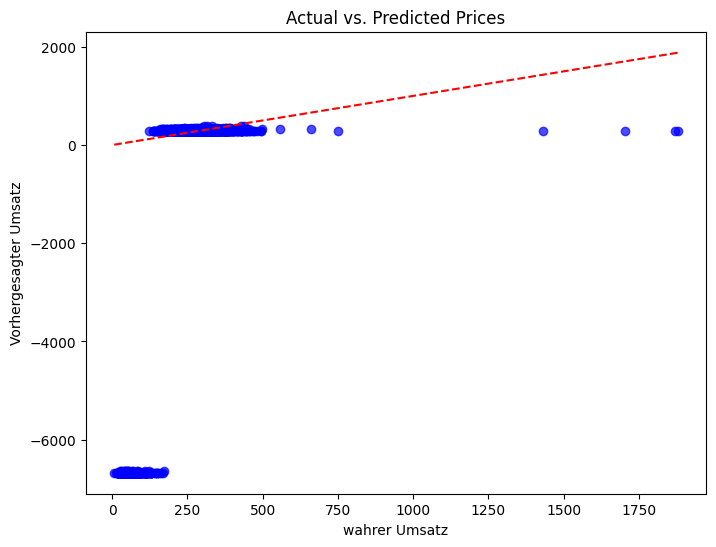

In [45]:
#nun kann ich meine vorgehersagten Werte mit den tatsächlichen Werten vergleichen
# Scatter plot: Actual vs. Predicted Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.7, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color="red")
plt.xlabel("wahrer Umsatz")
plt.ylabel("Vorhergesagter Umsatz")
plt.title("Actual vs. Predicted Prices")
plt.show()


In [53]:
#dataframe aus den vorhergesagten Werten erstellen
predictions_df = pd.DataFrame(predictions, columns=["Predicted"])
predictions_df.index = y_test.index
predictions_df["Actual"] = y_test
print(predictions_df.head())

#how can i match the predictions to the actual date they are referring to?
#i need to add the date column to the dataframe
data['Datum'] = pd.to_datetime(data['Datum'])
print(data.dtypes)
print(data.head())
print(data.tail())

#match the predictions to the actual date
predictions_df["Datum"] = data.loc[predictions_df.index, "Datum"]
print(predictions_df.head())

#match the prediction to the warengroup
predictions_df["Warengruppe_1"] = data.loc[predictions_df.index, "Warengruppe_1"]
predictions_df["Warengruppe_2"] = data.loc[predictions_df.index, "Warengruppe_2"]
predictions_df["Warengruppe_3"] = data.loc[predictions_df.index, "Warengruppe_3"]
predictions_df["Warengruppe_4"] = data.loc[predictions_df.index, "Warengruppe_4"]
predictions_df["Warengruppe_5"] = data.loc[predictions_df.index, "Warengruppe_5"]
predictions_df["Warengruppe_6"] = data.loc[predictions_df.index, "Warengruppe_6"]

print(predictions_df.head())

#create a new colum for the warengruppe where the values range from 1 to 6
predictions_df["Warengruppe"] = np.argmax(predictions_df[["Warengruppe_1", "Warengruppe_2", "Warengruppe_3", "Warengruppe_4", "Warengruppe_5", "Warengruppe_6"]].values, axis=1) + 1
print(predictions_df.head())

#create a new column for the made from date and warengruppe in the fomat 'YYMMDDWarengruppe'
predictions_df["Datum_Warengruppe"] = predictions_df["Datum"].dt.strftime('%y%m%d') + predictions_df["Warengruppe"].astype(str)
print(predictions_df.head())







       Predicted      Actual
7467  328.667969  251.572909
7468  328.667969  211.366012
7469  328.667969  265.958912
7470  290.746094  354.983558
7471  290.746094  194.366328
Datum                   datetime64[ns]
Umsatz                         float64
Warengruppe_1                    int64
Warengruppe_2                    int64
Warengruppe_3                    int64
Warengruppe_4                    int64
Warengruppe_5                    int64
Warengruppe_6                    int64
Temp_Very_Cold                   int64
Temp_Cold                        int64
Temp_Mild                        int64
Temp_Warm                        int64
Temp_Hot                         int64
Cloud_Clear                      int64
Cloud_Partly_Cloudy              int64
Cloud_Cloudy                     int64
Wind_Light                       int64
Wind_Moderate                    int64
Wind_Strong                      int64
Weather_Good                     int64
Weather_Light_Issues             int64
Weather

In [47]:
#versuchen meine vorhersagen auf das Format zu matchen, dass kaggle will
kaggle = pd.read_csv('../sample_submission.csv')
print(kaggle.head())

        id  Umsatz
0  1808011       0
1  1808021       0
2  1808031       0
3  1808041       0
4  1808051       0
